In [174]:
import os, glob, string, re, datetime
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import pandas as pd
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Extracting the Data
Know that we have learned that we will not be able to process the data using a Spark pipeline, we will implement here a Python pipeline to read the files.

## 1 - Extracting the paths

We first have to get all the paths containing the XML files.

In [204]:
GDL = 'GDL'
JDG = 'JDG'
listFiles = []

#Go through all the files of both journals
for root, dirs, files in os.walk(GDL): 
    for file in files:
        if file.endswith('.xml'):
             listFiles.append(os.path.join(root, file))

for root, dirs, files in os.walk(JDG): 
    for file in files:
        if file.endswith('.xml'):
             listFiles.append(os.path.join(root, file))

Now that we have the path for each file in the dataset, we can work through each of them and count words. We will use the method described in **Filtering the Data.ipynb**

## 2 - Extracting the word count
Know that we have the paths for all text files, we can read the text and then clean it.

First we need the stop words.

In [205]:
stop_words = list(stopwords.words('french'))
stop_words.extend(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']',
                   '{', '}', '<', '>', '...', '-', '•', '/', '%', '«', '»', 'le',
                  'les','..','©','plus','*','``','av','p.','fr','cette','a.','v.','b.','d.',
                   'c.','e.','f.','i.','g.','h.','i.','j.','l.','m.','n.','o.','q.','r.','q.',
                   's.','t.','u.','v.','w.','x.','z.','y.',"d'un","d'une",'dm',"c'est",
                   "jusqu'au",'entre','comme','si','di','„','&',"qu'il",'_','fd',"n'a",'alors',
                   "s'est","n'est",'cs','dès','où',"jusqu'à",'déjà',"''",'|','£','®','+','-«',
                   '--','.-',"la",'---','-le','-n','î','â'])

stop_words.extend(['','-.','.,','(,','»,',').','-.','av.','».',
                      '....','..','...','.....','()','(r).','—',')-«',
                      '".','-,','(-.',')-.','(©','™','--','---','—•','•-',
                  '•','••','•••','•••','—la','ï',"'la",'•—',
                  '——','û','ê','ë','ù',"'la",'•—','——','—le',"'''","''",
                  "'","'le","'la","'i",'-on',"•'","'-","-'","a'","'de","'la",
                  "'â","aa","'-","-de","-et",'-on','-les',',,,', '——•','•-•',
                  '„„','•—•','ils','ont','tous','tout','aussi','ans',
                  'on','quelque','dont','ainsi','après','aprè',
                  'depuis','deux','dont','leurs','leur','une',
                  'fait','faite','non','oui','dit','en',' ',
                  '  ','   ','    ','     ','      ','       ','        '])
stop_words.extend(list(string.ascii_lowercase))

And preparing the dictionaries.

In [206]:
listPunct = list(string.punctuation)
listPunct.remove("'")
listPunct.remove("-")
#we do not want to stick together all the words that
#have an apostrophe (l'armée should not become larmée)
stopDict = dict(zip(listPunct,['']*len(listPunct)))
#We want to break apart words with "'" and also replace some
#random characters that we saw appeared in the text
stopDict["'"] = ' '
stopDict["•"] = ''

We also need a constant which tells us how many of the most frequent words we take.

In [209]:
numMostFreq = 3000

And then we can go through the list to extract the data in each file. We also set a counter to see how long it takes.

We first extract the data in 43 different dataframes, otherwise the algorithm's complexity is too high and the process is endless.

In [211]:
total = len(listFiles)
allText = []

In [ ]:
for idx, file in tqdm(enumerate(listFiles)):   
    #find the date at which the article is published.
    date = pd.to_datetime(file[4:11])
    #Open the XML
    f = open(file,'r')
    soupArticle = BeautifulSoup(f,'lxml')
    f.close()
    
    #Extracting the entire text from the XML
    Article = []
    for ft in soupArticle.find_all('full_text'):
        #Here we lower each words and we remove the numbers from the text
        Article.append(re.sub(r'\d+', '', ft.text).lower())

    textArticle = ' '.join(Article)  
    
    #Cleaning and counting
    for k,v in stopDict.items():
        textArticle = textArticle.replace(k,v)

    dictCounter = [wordsDict for wordsDict in textArticle.split(' ') if wordsDict not in stop_words]
    countDict = Counter(dictCounter).most_common(numMostFreq)
    
    #Transofming to a dataframe
    df = pd.DataFrame(countDict).transpose()
    df.columns = df.loc[0]
    df.drop(0,inplace=True)
    df.index = [date]
    allText.append(df)
    
    if idx > 0:
        if idx%50 == 0:
            dfAllText = pd.concat(allText,axis=0)
            dfAllText.to_csv('3_Data/Part_'+str(idx)+'.csv')
            del allText
            allText = []
  

3it [00:04,  1.75s/it]

In [ ]:
dfAllText.to_csv('3_Data/Part_end.csv')

Now that we have all the separate dataframes we can implement a function to concatenate them together.

In [27]:
csvFiles = []

for root, dirs, files in os.walk('3_Data'): 
    for file in files:
        if file.endswith('.csv'):
             csvFiles.append(pd.read_csv(os.path.join(root, file),
                                         index_col=0))

And now we can concatenate all of the separate DataFrames!

In [31]:
dfFinal = pd.concat(csvFiles,axis=0)

Now we look at the results!

In [79]:
print('Number of words : ',dfFinal.shape[1])
origShape = dfFinal.shape 

Number of words :  130856


We have a lot of words, as we saw before, we still have a lot of unwanted words and random punctuations signs that we were not able to remove during the cleaning.

In [41]:
dfFinal.columns

Index(['''''', ''''''', '''''''', ''''''''', '''''''''''', '''''''„''',
       '''''-', '''''ch', '''''•', '''''•'''',
       ...
       '••••»', '•••••', '••••••', '•••••••', '••••••••', '€', '™'', '™-',
       '™™', '™™™™'],
      dtype='object', length=130856)

# First Cleaning Steps

We will begin by performing a little bit of rough cleaning before going into NLP cleaning.

We begin by getting rid of the columns that have random signs.

In [78]:
dfFinal.columns[0:1695]

Index(['''''', ''''''', '''''''', ''''''''', '''''''''''', '''''''„''',
       '''''-', '''''ch', '''''•', '''''•'''',
       ...
       'aaland', 'aalandais', 'aalen', 'aalesund', 'aan', 'aandoz', 'aap',
       'aar', 'aar-horn', 'aar-tessin'],
      dtype='object', length=1695)

In [80]:
dfFinal.drop(dfFinal.columns[0:1695],axis=1, inplace=True)
dfFinal.shape

(4351, 129161)

In [118]:
dfFinal.columns[128710:]

Index(['—'', '—'a', '—'le', '—'—', '—-', '—--', '—-a', '—-au', '—-d'après',
       '—-dans',
       ...
       '••••»', '•••••', '••••••', '•••••••', '••••••••', '€', '™'', '™-',
       '™™', '™™™™'],
      dtype='object', length=451)

In [119]:
dfFinal.drop(dfFinal.columns[128710:],axis=1, inplace=True)
dfFinal.shape

(4351, 128710)

And we also see that we have two indexes per month, therefore we can groupby.

In [121]:
dfFinal = dfFinal.fillna(0)
year = dfFinal.groupby(by='index',level=0)

And aggregate per year.

In [123]:
yearData = year.agg(sum)
yearData.head()

,aara,aarau,aarberg,aarbourg,aardman,aarg,aargau,aarif,aarmiihle,aarrêté,...,œrebro,œri,œrlikon,œsthéliques,œtpnde,œuf,œufs,œuvr,œuvre,œuvres
1798-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Setting the index in datetime to be able to plot dates.

In [136]:
yearData.index = pd.to_datetime(yearData.index)
yearIndex = yearData.index

In [133]:
sumYear = yearData.sum(axis=1)

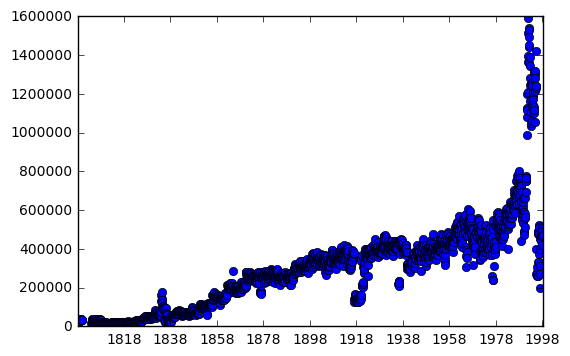

In [143]:
plt.plot_date(yearIndex,sumYear.values)

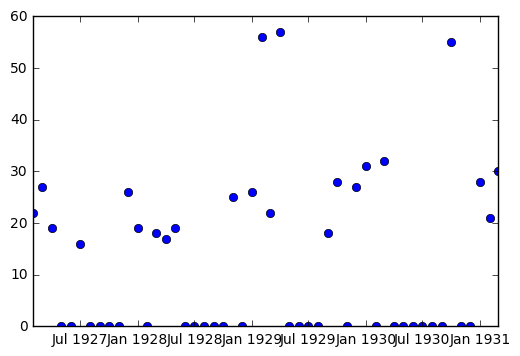

In [161]:
plt.plot_date(yearIndex[1500:1550],yearData['hiver'].values[1500:1550])

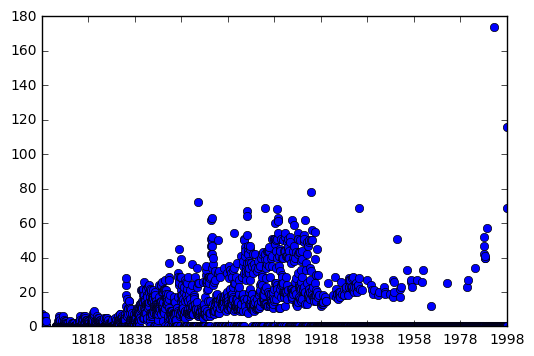

In [190]:
plt.plot_date(yearIndex,yearData['cri'].values)

In [191]:
yearData.to_csv('3kwordCountYear.csv')